In [1]:
# Understanding Data Augmentation and its application in Computer Vision
# We will also learn various ways of data augmentation and ways to integrate it with pipeline.

# It's a technique to increase diversity and generalisation in training dataset for better feature learning of model.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [3]:
# Download and load an image dataset
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [4]:
# number of different classes
num_classes = metadata.features['label'].num_classes
num_classes

5

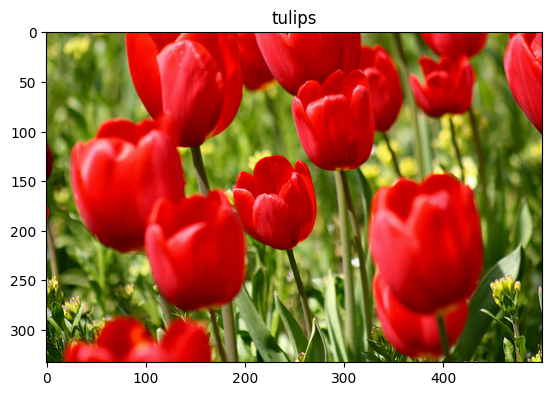

In [20]:
get_label_name = metadata.features['label'].int2str

# Display data as an image and set a title for the axes.
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [6]:
# Data augmentation is part of Preprocessing Layer.
# 1. we can use Keras Preprocessing layer (layers.experimental.preprocessing) for various types of
#    augmentation techniques for image processing.

# First we need to resize and rescale the images, so that all images should be of smae dimensions and in same range of pixel values.
IMG_SIZE = 180
resize_rescale_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

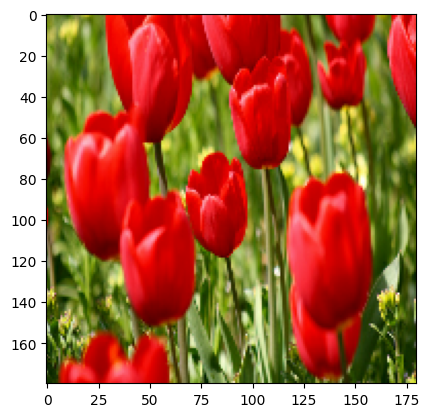

In [9]:
plt.imshow(resize_rescale_layer(image))

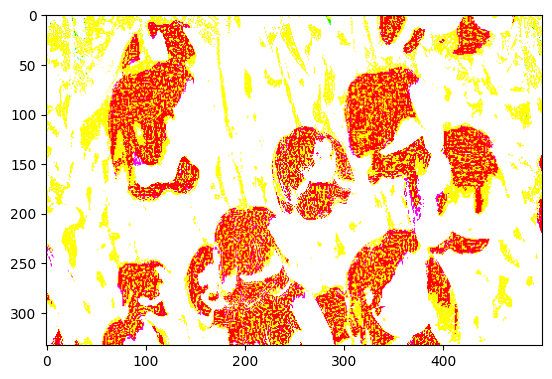

In [23]:
# Different types of augmentation functions in preprocessing layers:
# 1. Random flip : randomly flipping the image horizontally or vertically.


randomflip = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical")
])

plt.imshow(randomflip(image))


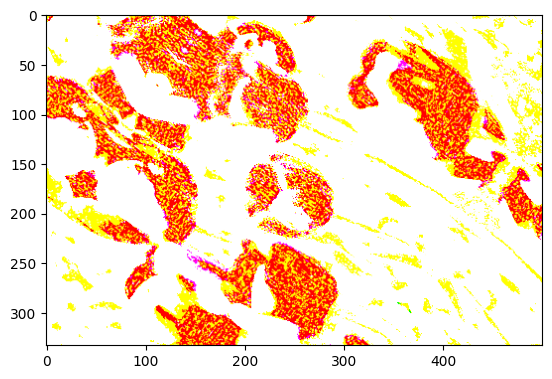

In [25]:
# 2. Random rotation : randomly rotate the image to x*(90 degree)


randomRotation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.3)
])

plt.imshow(randomRotation(image))

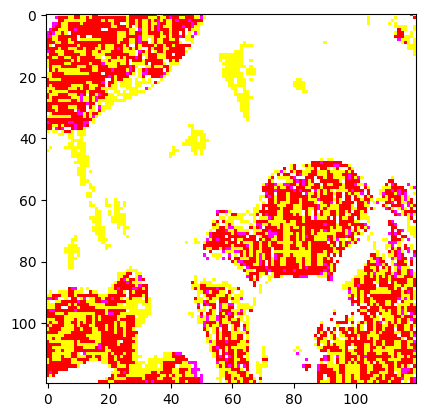

In [27]:
# 3. Random cropping : randomly crop the image to w*h dimension


randomCrop = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomCrop(120, 120)
])

plt.imshow(randomCrop(image))

In [ ]:
# 4. Random contrast : randomly changing contrast of the image


randomContrast = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomContrast(0.5)
])

plt.imshow(randomContrast(image))

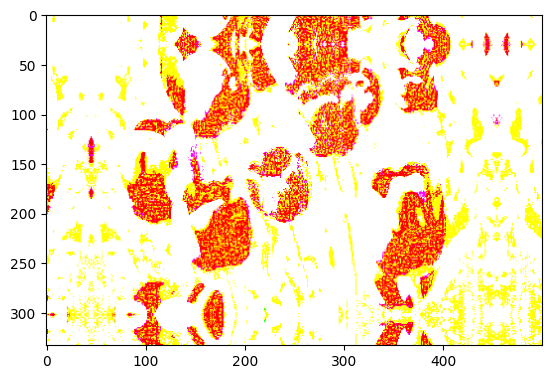

In [35]:
# 5. Random zoom : randomly changing zoom of the image


randomZoom = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomZoom(0.3)
])

plt.imshow(randomZoom(image))

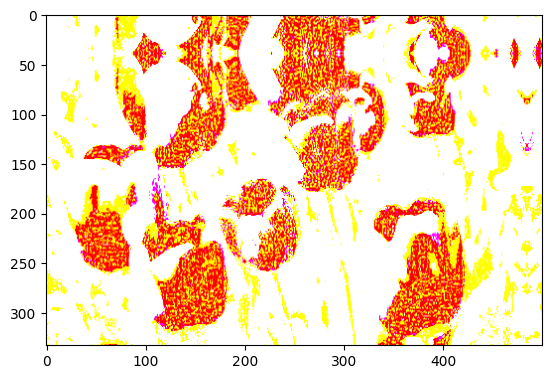

In [37]:
# 6. Random translation : randomly shifting of the image in the plane


randomTranslation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomTranslation(0.3, 0.3)
])

plt.imshow(randomTranslation(image))

In [ ]:
# there are many more augmentation types like RamdonWidth, RandomHeight, RandomBrightness etc.

In [38]:
# We can combine all these augmentation layers into one function
augmentation_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomCrop(120, 120),
    layers.experimental.preprocessing.RandomTranslation(0.3, 0.3),
    layers.experimental.preprocessing.RandomContrast(0.5),
    layers.experimental.preprocessing.RandomZoom(0.3)
])

In [ ]:
# Lets integrate these layers in model pipeline
# 1. Make the preprocessing layers part of your model

# Note: Data augmentation is inactive at test time so input images will only be
#       augmented during calls to model.fit (not model.evaluate or model.predict).

model = tf.keras.Sequential([
  resize_rescale_layer,
  augmentation_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model
])


'''
There are two important points to be aware of in this case:

1. Data augmentation will run on-device, synchronously with the rest of your layers,
  and benefit from GPU acceleration.

2. When you export your model using model.save, the preprocessing layers will
   be saved along with the rest of your model. If you later deploy this model,
   it will automatically standardize images (according to the configuration of your layers).
   This can save you from the effort of having to reimplement that logic server-side.
'''

In [40]:
# 2: Apply the preprocessing layers to your dataset

'''
With this approach, you use Dataset.map to create a dataset that yields
 batches of augmented images. In this case:

Data augmentation will happen asynchronously on the CPU, and is non-blocking.
You can overlap the training of your model on the GPU with data preprocessing,
using Dataset.prefetch, shown below.
In this case the prepreprocessing layers will not be exported with the model
when you call model.save. You will need to attach them to your model before saving
it or reimplement them server-side. After training, you can attach the preprocessing
layers before export.
'''

batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_rescale_layer(x), y),
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (augmentation_layer(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# apply on datasets:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [ ]:
# create and build the model

model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# Config the model with losses and metrics with model.compile()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Train the model with model.fit()
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

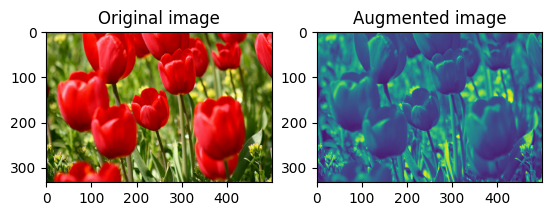

In [41]:
'''  tf.image '''
# In order to have finer control, we can create augmentation and comnbine it with
# data pipeline using tf.data and tf.image.

def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

# e.g:
# 1. Convert to grayscale

visualize(image, tf.image.rgb_to_grayscale(image))


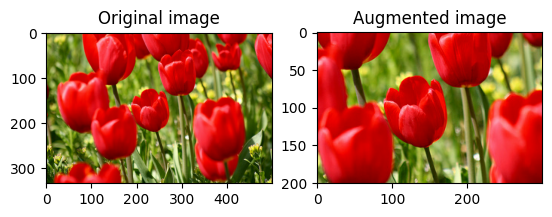

In [42]:
# 2. crop the image
visualize(image, tf.image.central_crop(image, 0.6))

In [44]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.int32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = image/255.0
  return image, label


def data_augmentation(image, label):

  image, label = resize_and_rescale(image, label)

  image = tf.image.central_crop(image, 0.3)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  image = tf.image.rot90(image)
  image = tf.image.adjust_brightness(image, 0.3)
  image = tf.clip_by_value(image, 0, 1)

  return image, label


In [ ]:
# Lets cofigure the training, validation and test dataset for creating data pipeline parallel processing

train_ds = (
    train_ds
    .shuffle(1000)
    .map(data_augmentation, num_parallel_calls = AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
    )

val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls = AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls = AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
